# US Retail Sales - Hybrid Model

Experiment with Time Series Forecasting using Hybrid Models.

# Notebook Setup

## Imports

In [1]:
# Import Standard Libraries
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

# Ignore warnings
simplefilter("ignore")

## Plot Characteristics

In [3]:
# Setup plot characteristics
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

# Read Data

In [11]:
# Read dataset with Pandas
data = pd.read_csv('./../../data/raw/us_retail_sales.csv',
                   usecols=['Month', 'BuildingMaterials', 'FoodAndBeverage'],
                   parse_dates=['Month'],
                   index_col='Month').to_period('D').reindex(columns=['BuildingMaterials', 'FoodAndBeverage'])

# Refine dataframe structure
data = pd.concat({'Sales': data}, names=[None, 'Industries'], axis=1)

In [18]:
data.tail()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
2019-08-01             32375           66937
2019-09-01             29963           62420
2019-10-01             32629           64849
2019-11-01             29793           66363
2019-12-01             28621           70028

# Data Preparation

## Create Trend Features

In [13]:
# Define y
y = data.copy()

In [14]:
# Define the Deterministic Process
deterministic_process = DeterministicProcess(
    index=y.index, 
    constant=True,
    order=2,
    drop=True
)

In [16]:
# Define x
x = deterministic_process.in_sample()

## Train & Test Split

In [19]:
# Use the last 4 years as a test set
idx_train, idx_test = train_test_split(
    y.index, 
    test_size=12 * 4, 
    shuffle=False
)

In [20]:
# Split data
x_train, x_test = x.loc[idx_train, :], x.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Model Training

## Linear Regression

Use a Linear model to extrapolate the **Trend** component.

In [22]:
# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(x_train, y_train)

LinearRegression(fit_intercept=False)

# Model Evaluation

## Linear Regression

In [23]:
# Compute predictions for the training data
y_train_predictions = pd.DataFrame(
    model.predict(x_train),
    index=y_train.index,
    columns=y_train.columns,
)

# Compute predictions for the test data
y_test_predictions = pd.DataFrame(
    model.predict(x_test),
    index=y_test.index,
    columns=y_test.columns,
)

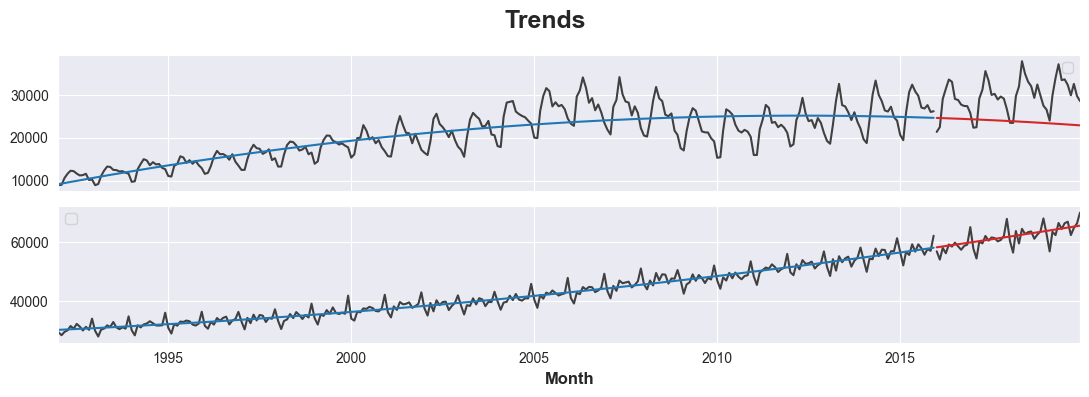

In [24]:
# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_train_predictions.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_test_predictions.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")